## Libraries

In [2]:
import nibabel as nib
import os
import pandas as pd
import nibabel as nib
import numpy as np
import SimpleITK as sitk
from PIL import Image
from collections import defaultdict
import math

## Variables

In [3]:
data_path = "/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData"

## Functions

In [4]:
def organ_mapper():
    label_dict = {
        0: "background",
        1: "spleen",
        2: "right kidney",
        3: "left kidney",
        4: "gallbladder",
        5: "esophagus",
        6: "liver",
        7: "stomach",
        8: "aorta",
        9: "inferior vena cava",
        10: "portal vein & splenic vein",
        11: "pancreas",
        12: "right adrenal gland",
        13: "left adrenal gland",
    }
    key_to_organ = label_dict
    organ_to_key = {v.lower(): k for k, v in label_dict.items()}
    return key_to_organ, organ_to_key


def transform_to_csv(data_root):
    """
    Transform the BTCV dataset to a csv file.
    Args:
        data_root (str): path to the BTCV dataset.

    Returns:
        annotations (list): list of dictionaries containing the images and their masks with a list of organs available in each scan.

    """

    annotations = []
    images_dir = os.path.join(data_root, "imagesTr")
    masks_dir = os.path.join(data_root, "labelsTr")
    imgs = [images_dir + "/" + f for f in sorted(os.listdir(images_dir))]
    masks = [masks_dir + "/" + f for f in sorted(os.listdir(masks_dir))]

    for img_path, mask_path in zip(imgs, masks):
        mask_nifti = nib.load(mask_path)
        mask_data = mask_nifti.get_fdata()
        organs = [int(organ) for organ in np.unique(mask_data).tolist()]
        annotations.append(
            {"img_path": img_path, "mask_path": mask_path, "organs": organs}
        )

    annotations_df = pd.DataFrame(annotations)
    # Save to CSV
    annotations_df.to_csv(os.path.join(data_root, "dataset.csv"), index=False, sep=",")

    return annotations

In [5]:
def clip_and_rescale(ct_array, min_hu=-175, max_hu=250):
    clipped = np.clip(ct_array, min_hu, max_hu)
    return (clipped + abs(min_hu)) / (max_hu + abs(min_hu))

def to_tensor(image, mask):
    img_t = torch.from_numpy(image).float().unsqueeze(0)  # or permute channels
    msk_t = torch.from_numpy(mask).float().unsqueeze(0)
    return img_t, msk_t

def save_as_png(nii_path, output_dir, z):
    """
    Save the input in the output directory as png file.
    Args:
        nii_path (string): path of the input
        output_dir (string): path of the output directory
        z (int): index of the slice
    """
    base_name = os.path.basename(nii_path).replace(".nii.gz", "")
    slice_name = f"{base_name}_slice{z:03d}.png"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, slice_name)

    return output_path

# 2D Dataset

In [15]:
def load_n_slices_per_organ(annotations ,organs, n_slices):
    """
    Load a specific number of slices from the BTCV dataset.
    Args:
        n_slices (int): Number of slices to load.

    Returns:
        slices_df (list): List of loaded slices.
    """
    slices_df = []
    key_to_organ, organ_to_key = organ_mapper()
    for annotation in annotations:
        for organ in organs:
            organ_key = organ_to_key.get(organ)
            if organ_key not in annotation["organs"]:
                print(f"Organ {organ} not found in annotation for {annotation['img_path']}. Skipping.")
                continue
            img_path = annotation["img_path"]
            mask_path = annotation["mask_path"]
            img = sitk.ReadImage(img_path)
            mask = sitk.ReadImage(mask_path)
            img_arr = sitk.GetArrayFromImage(img)  # Shape: (Depth, Height, Width)
            mask_arr = sitk.GetArrayFromImage(mask)  # Shape: (Depth, Height, Width)

            
            slices_with_organ = np.any(mask_arr == organ_key, axis=(1, 2))
            slice_indices = np.where(slices_with_organ)[0].tolist()
            middle_slice = (slice_indices[-1] + slice_indices[0]) // 2
            slices_counter = 0
            for i in range(middle_slice - round((n_slices) / 2), middle_slice + math.ceil(n_slices / 2) + 1):
                slices_df.append(
                    {
                        "img_path": img_path,
                        "mask_path": mask_path,
                        "slice_index": i,
                        "organ": organ,
                    }
                )
                slices_counter += 1
                if slices_counter >= n_slices:
                    break
                
    slices_df = pd.DataFrame(slices_df)
    return slices_df


In [7]:
annotations =  transform_to_csv(data_path)
annotations

[{'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_000_0000.nii.gz',
  'mask_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/labelsTr/img_000.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_001_0000.nii.gz',
  'mask_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/labelsTr/img_001.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_002_0000.nii.gz',
  'mask_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/labelsTr/img_002.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_003_0000.nii.gz',
  'mask_path': '/home/ismail/pr

In [8]:
annotations_df = pd.read_csv(os.path.join(data_path, "dataset.csv"))
# annotations = annotations_df.to_dict(orient='records')

In [9]:
labels_path = data_path+ "/labelsTr"
total_slices = 0
for filename in sorted(os.listdir(labels_path)):
    mask_file = os.path.join(labels_path,filename)
    mask_obj = nib.load(mask_file)
    mask_data = mask_obj.get_fdata()
    total_slices += mask_data.shape[2]
    # print(f"{filename} : shape {mask_data.shape[2]}")

print(f"Total slices in all masks: {total_slices}")

Total slices in all masks: 3779


## Picking n_slices from the center of the organ

In [10]:
organs_list = ["liver", "spleen", "right kidney", "left kidney"]

In [18]:
slices_df = load_n_slices_per_organ(annotations,organs_list, 5)

In [19]:
slices_df.to_csv(os.path.join(data_path, "slices_dataset.csv"), index=False, sep=",")

In [4]:
slices_df = pd.read_csv(os.path.join(data_path, "slices_dataset.csv"))

In [5]:
slices_df

,img_path,mask_path,slice_index,organ
0,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,96,liver
1,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,97,liver
2,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,98,liver
3,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,99,liver
4,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,100,liver
...,...,...,...,...
595,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,89,left kidney
596,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,90,left kidney
597,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,91,left kidney
598,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNet...,92,left kidney


In [46]:
slices_df.shape

(600, 4)

## Plotting the slices

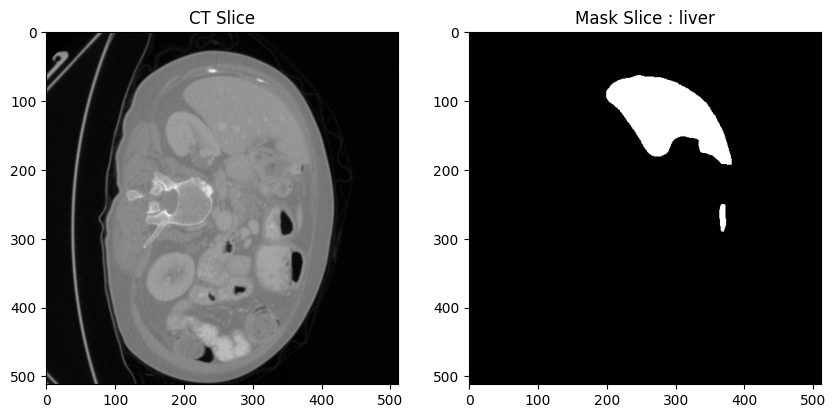

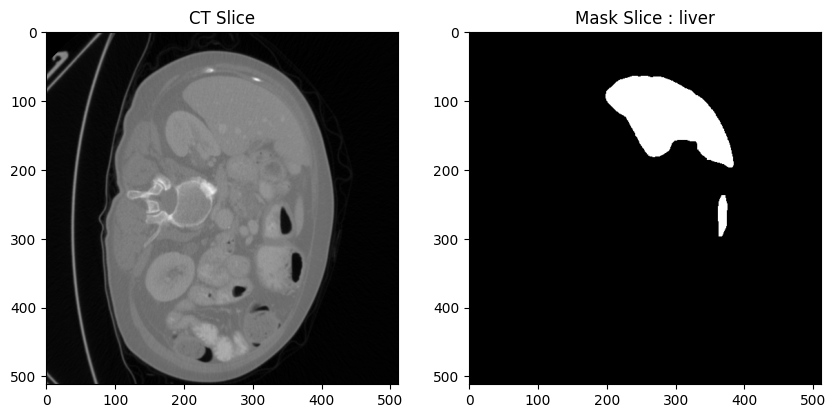

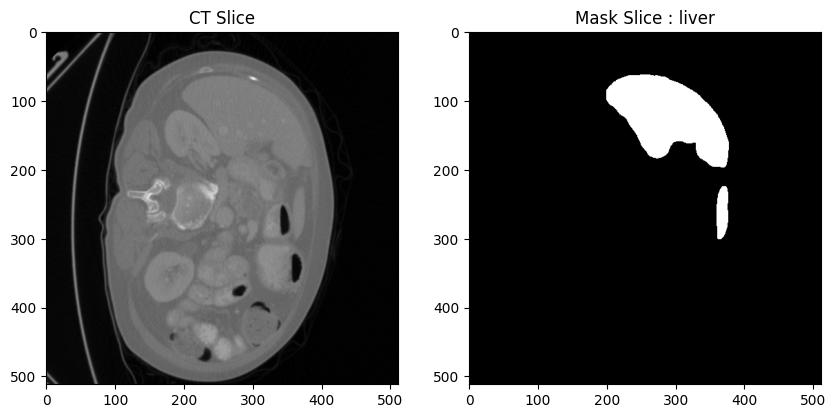

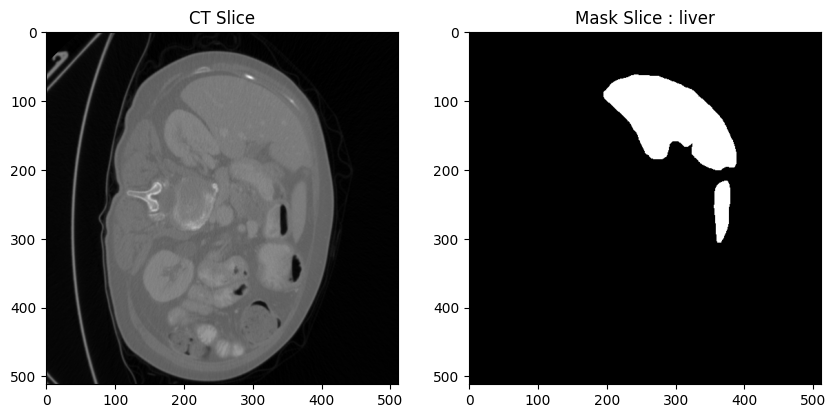

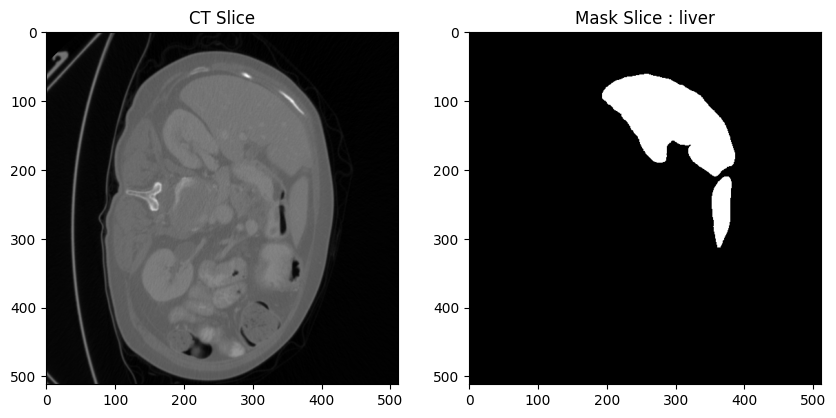

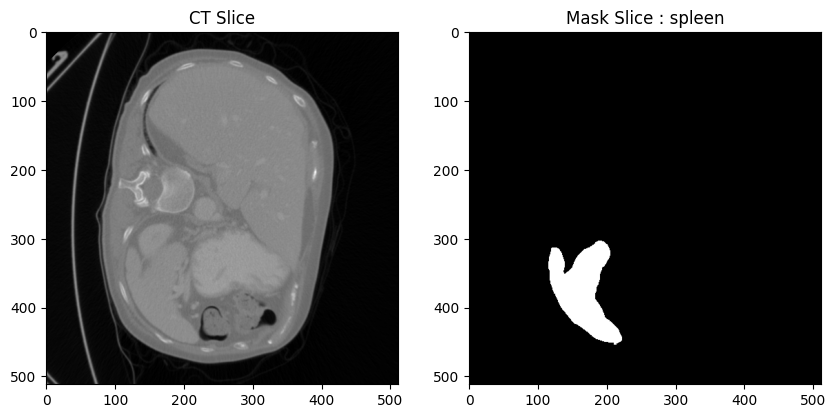

In [41]:
import matplotlib.pyplot as plt

key_to_organ ,organ_to_key = organ_mapper()

for _, slice_row in slices_df[0:6].iterrows():
    target_organ = slice_row["organ"]
    img = nib.load(slice_row["img_path"])
    mask = nib.load(slice_row["mask_path"])

    mask_slice = mask.dataobj[:,:, slice_row["slice_index"]]
    binary_mask = (mask_slice == organ_to_key[target_organ]).astype(np.uint8)
    # print(np.unique(binary_mask))
    img_slice = img.dataobj[:,:, slice_row["slice_index"]]
    # print(np.unique(mask_slice)) 
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_slice, cmap='gray')
    plt.title("CT Slice")
    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title(f"Mask Slice : {target_organ}")

plt.show()

## Save to PNG

In [55]:
def BTCV_load(annotations_df, organ, n_slices=5):
    """
    Load a specific number of slices from the BTCV dataset.
    Args:
        annotations_df (pd.DataFrame): DataFrame containing image and mask paths.
        organ (str): Organ to filter by.
        n_slices (int): Number of slices to load.

    Returns:
        slices_df (pd.DataFrame): DataFrame with loaded slices.
    """
    key_to_organ, organ_to_key = organ_mapper()
    if organ not in organ_to_key:
        raise ValueError(f"Organ {organ} not found in the dataset.")

    slices_df = load_n_slices_per_organ(annotations_df.to_dict(orient='records'), [organ], n_slices)
    return slices_df

def BTCV_save_as_png(slices_df, output_dir):
    """
    Save slices from the BTCV dataset as PNG files.
    Args:
        slices_df (pd.DataFrame): DataFrame containing slice information.
        output_dir (str): Directory to save PNG files.
    """
    

    for _, row in slices_df.iterrows():
        img_path = row["img_path"]
        mask_path = row["mask_path"]
        slice_index = row["slice_index"]
        organ = row["organ"]

        img = nib.load(img_path)
        mask = nib.load(mask_path)

        img_slice = img.dataobj[:, :, slice_index]
        mask_slice = mask.dataobj[:, :, slice_index]
        binary_mask = (mask_slice == organ_to_key[organ]).astype(np.uint8)
        img_output_dir = os.path.join(output_dir, organ ,"imgsTr")
        mask_output_dir = os.path.join(output_dir,organ, "labelsTr")
        output_img_path = save_as_png(img_path, img_output_dir, slice_index)
        output_mask_path = save_as_png(mask_path, mask_output_dir, slice_index)
        
        plt.imsave(output_img_path, img_slice, cmap='gray')
        plt.imsave(output_mask_path, binary_mask, cmap='gray')

In [56]:
output_dir = os.path.join(data_path, "Abdomen_2D")
BTCV_save_as_png(slices_df, output_dir)

# 3D Dataset